In [192]:
import pandas as pd
import requests
import json
%pylab inline
plt.style.use('ggplot')

Populating the interactive namespace from numpy and matplotlib


In [2]:
file_request = requests.get("https://openfecdata.blob.core.windows.net/fecfilings/processed_output/cross_contributions.json/part-00000")
file_lines = [json.loads(l) for l in file_request.text.split('\n') if l]

In [ ]:
df = pd.DataFrame(file_lines)
df_column_map = {
    'COUNT(contributions)': "NumContributions",
    'SUM(contributions)': "SumContributions",
    'district': "SourceDistrict",
    'state': "SourceState"
}
df.columns = [df_column_map.get(c, c) for c in df.columns]
df.CAND_OFFICE_DISTRICT = df.CAND_OFFICE_DISTRICT.apply(int)
df.SourceDistrict = df.SourceDistrict.apply(int)
df["WithinDistrict"] = (df.CAND_OFFICE_DISTRICT == df.SourceDistrict) & (df.CAND_OFFICE_ST == df.SourceState)

In [22]:
df_donor_districts = df.pivot_table(index=["SourceState", "SourceDistrict"], columns="WithinDistrict", values="SumContributions", aggfunc=sum, fill_value=0).reset_index()
df_donor_districts.columns = ['SourceState', 'SourceDistrict', 'DonateToOther', 'DonateToSelf']
df_donor_districts["DonateToSelfRatio"] = df_donor_districts.DonateToSelf / (df_donor_districts.DonateToSelf + df_donor_districts.DonateToOther)

In [26]:
df_donor_districts.sort('DonateToSelfRatio', ascending=True).head(10)

,SourceState,SourceDistrict,DonateToOther,DonateToSelf,DonateToSelfRatio
77,CO,4,440082,0.00,0.000000
185,MA,7,8427341,7096.11,0.000841
229,MS,2,359284,750.00,0.002083
286,NY,16,821912,2300.00,0.002791
378,TX,18,719925,2500.00,0.003461
63,CA,43,168405,650.00,0.003845
118,GA,5,841142,4000.00,0.004733
206,MI,9,1671904,8200.00,0.004881
117,GA,4,154111,1000.00,0.006447
353,TN,2,344104,2388.15,0.006892


In [27]:
df_donor_districts.sort('DonateToSelfRatio', ascending=False).head(10)

,SourceState,SourceDistrict,DonateToOther,DonateToSelf,DonateToSelfRatio
197,ME,2,17500,567034.18,0.970062
228,MS,1,24007,696139.17,0.966664
162,IN,9,78025,1098333.22,0.933672
176,LA,4,55691,544470.40,0.907207
379,TX,19,108081,998124.78,0.902296
250,NH,1,137489,1222515.00,0.898905
227,MO,8,16330,136430.00,0.893100
44,CA,24,247125,1958564.03,0.887960
432,WV,2,40927,321495.60,0.887074
13,AZ,2,330164,2359298.35,0.877238


In [39]:
df_recipient_districts = df.pivot_table(index=["CAND_OFFICE_ST", "CAND_OFFICE_DISTRICT"], columns="WithinDistrict", values="SumContributions", aggfunc=sum, fill_value=0).reset_index()
df_recipient_districts.columns = ['RecipientState', 'RecipientDistrict', 'DonateFromOther', 'DonateFromSelf']
df_recipient_districts["DonateFromSelfRatio"] = df_recipient_districts.DonateFromSelf / (df_recipient_districts.DonateFromOther + df_recipient_districts.DonateFromSelf)

In [42]:
df_recipient_districts.sort("DonateFromSelfRatio", ascending=False).head(10)

,RecipientState,RecipientDistrict,DonateFromOther,DonateFromSelf,DonateFromSelfRatio
378,TX,15,104066,916621.46,0.898043
355,TN,1,30659,140945.00,0.821339
382,TX,19,244967,998124.78,0.802937
214,MN,2,536666,1191426.17,0.689446
252,NH,1,643218,1222515.00,0.655246
105,FL,19,29490,52168.36,0.638861
177,LA,4,421759,544470.40,0.563500
353,SC,7,149800,187249.97,0.555556
197,ME,1,36000,44616.00,0.553439
86,DE,0,258928,315257.19,0.549051


In [44]:
df_recipient_districts.sort("DonateFromSelfRatio", ascending=True).head(10)

,RecipientState,RecipientDistrict,DonateFromOther,DonateFromSelf,DonateFromSelfRatio
128,GU,0,12400,0,0.000000
344,PR,0,36050,0,0.000000
404,VA,0,60350,0,0.000000
416,VI,0,8560,0,0.000000
85,DC,0,75250,0,0.000000
229,MP,0,2000,0,0.000000
231,MS,2,192795,750,0.003875
63,CA,43,82075,650,0.007857
233,MS,4,85600,750,0.008686
400,UT,1,170350,1500,0.008729


In [50]:
df_recipient_districts[df_recipient_districts.RecipientState == "WA"]

,RecipientState,RecipientDistrict,DonateFromOther,DonateFromSelf,DonateFromSelfRatio
418,WA,1,325595,72321.06,0.181750
419,WA,2,148798,10600.00,0.066500
420,WA,3,123770,108635.56,0.467440
421,WA,4,287178,107333.22,0.272066
422,WA,5,526314,93981.00,0.151510
423,WA,6,400891,94244.00,0.190340
424,WA,7,86900,36645.00,0.296613
425,WA,8,255149,35315.63,0.121583
426,WA,9,302941,7300.00,0.023530
427,WA,10,204351,56551.00,0.216752


In [51]:
df_donor_districts[df_donor_districts.SourceState == "WA"]

,SourceState,SourceDistrict,DonateToOther,DonateToSelf,DonateToSelfRatio
413,WA,1,370295,72321.06,0.163395
414,WA,2,132813,10600.00,0.073912
415,WA,3,100192,108635.56,0.520217
416,WA,4,42816,107333.22,0.714844
417,WA,5,55967,93981.00,0.626757
418,WA,6,59405,94244.00,0.613372
419,WA,7,450123,36645.00,0.075282
420,WA,8,147455,35315.63,0.193224
421,WA,9,697917,7300.00,0.010351
422,WA,10,118526,56551.00,0.323006


In [53]:
df_donor_districts.sort("DonateToOther", ascending=False).head(10)

,SourceState,SourceDistrict,DonateToOther,DonateToSelf,DonateToSelfRatio
408,VA,8,15741659,157863.62,0.009929
185,MA,7,8427341,7096.11,0.000841
282,NY,12,6480177,216676.02,0.032355
411,VA,11,5480489,72030.94,0.012973
280,NY,10,3560187,180160.81,0.048167
410,VA,10,3444826,616084.00,0.151711
108,FL,22,3043944,127764.75,0.040283
53,CA,33,3009517,178201.97,0.055903
142,IL,7,2935345,37020.00,0.012455
195,MD,8,2840440,841024.33,0.228448


In [113]:
df_donor_districts.sort("DonateToOther", ascending=True).head(10)

,SourceState,SourceDistrict,DonateToOther,DonateToSelf,DonateToSelfRatio
285,NY,15,14939,2500.00,0.143357
227,MO,8,16330,136430.00,0.893100
197,ME,2,17500,567034.18,0.970062
228,MS,1,24007,696139.17,0.966664
352,TN,1,26920,140945.00,0.839633
0,AK,0,27822,77648.42,0.736210
249,NE,3,28033,68072.14,0.708309
346,SC,3,28480,24837.36,0.465840
231,MS,4,28880,750.00,0.025312
125,GA,12,29437,52925.00,0.642590


In [188]:
df_recipient_districts.sort("DonateFromOther", ascending=False).head()

,RecipientState,RecipientDistrict,DonateFromOther,DonateFromSelf,DonateFromSelfRatio
13,AZ,2,8139273,2359298.35,0.224726
104,FL,18,5378459,1532858.25,0.221790
43,CA,23,4299119,253764.76,0.055737
428,WI,1,3421984,80545.01,0.022996
192,MD,4,3360169,702751.71,0.172967


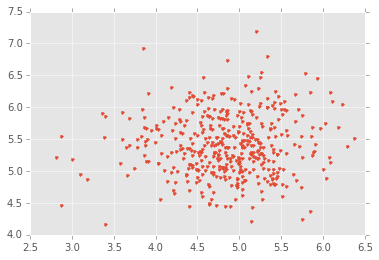

In [193]:
plot(log10(df_donor_districts.DonateToSelf),log10(df_donor_districts.DonateToOther), '.')

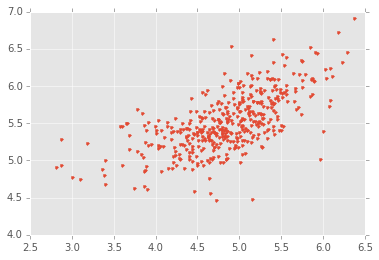

In [194]:
plot(log10(df_recipient_districts.DonateFromSelf),log10(df_recipient_districts.DonateFromOther), '.')

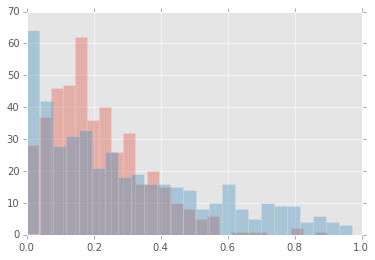

In [201]:
df_recipient_districts.DonateFromSelfRatio.hist(bins=25, alpha=.35)
df_donor_districts.DonateToSelfRatio.hist(bins=25, alpha=.35)

In [185]:
df_donor_districts.corr('kendall')

,SourceDistrict,DonateToOther,DonateToSelf,DonateToSelfRatio
SourceDistrict,1.000000,0.181427,-0.028744,-0.152183
DonateToOther,0.181427,1.000000,0.015330,-0.441559
DonateToSelf,-0.028744,0.015330,1.000000,0.543123
DonateToSelfRatio,-0.152183,-0.441559,0.543123,1.000000


In [186]:
df_recipient_districts.corr('kendall')

,RecipientDistrict,DonateFromOther,DonateFromSelf,DonateFromSelfRatio
RecipientDistrict,1.000000,0.099288,-0.002317,-0.094024
DonateFromOther,0.099288,1.000000,0.485210,0.008004
DonateFromSelf,-0.002317,0.485210,1.000000,0.522778
DonateFromSelfRatio,-0.094024,0.008004,0.522778,1.000000


In [55]:
# Next up: combine with other info:
#   previous race competitiveness
#   demographics:
#     race
#     median income

In [79]:
df_demographics_raw = pd.read_csv("http://proximityone.com/countytrends/cd11414dp1.csv", header=None)

In [107]:
offset = 2
demographics_cols = [0, 28 + offset, 32 + offset, 33 + offset, 34 + offset, 39 + offset, 53 + offset, 66 + offset]
demographics_labels = ['StateDistrict', 'TotalPop', 'White', 'BlackAA', 'AmericanIndian', 'Indian', 'TwoOrMore', 'Hispanic']
df_demographics_subset = df_demographics_raw[demographics_cols].copy()
df_demographics_subset.columns = demographics_labels

In [88]:
df_demographics_subset.head()

,StateDistrict,TotalPop,White,BlackAA,AmericanIndian,Indian,TwoOrMore,Hispanic
0,AL01,696783,468456,194320,5293,9757,11719,21560
1,AL02,678622,443780,209361,3409,7684,8867,21732
2,AL03,706574,492627,183400,1988,9979,12527,21219
3,AL04,683372,596472,46899,5010,3536,13816,40923
4,AL05,706373,542208,121562,4100,10138,20695,34993


In [89]:
df_economics_raw = pd.read_csv("http://proximityone.com/countytrends/cd11414dp3.csv", header=None)

In [108]:
economics_cols = [0, 1 + offset, 2 + offset, 3 + offset, 4 + offset, 5 + offset, 9 + offset, 62 + offset, 75 + offset]
economics_labels = ['StateDistrict', 'TotalPopOver16', 'LaborForce', 
                    'CivilianLaborForce', 'CivilianLaborForceEmployed', 
                    'CivilianLaborForceUnemployed', 'UnemploymentRate', 
                    'MedianHouseholdIncome', 'PeopleOnFoodStamps']
df_economics_subset = df_economics_raw[economics_cols].copy()
df_economics_subset.columns = economics_labels

In [91]:
df_economics_subset.head()

,StateDistrict,TotalPopOver16,LaborForce,CivilianLaborForce,CivilianLaborForceEmployed,CivilianLaborForceUnemployed,UnemploymentRate,MedianHouseholdIncome,PeopleOnFoodStamps
0,AL01,553082,311302,310102,284368,25734,8.3,44030,171735
1,AL02,539419,311124,304679,276724,27955,9.2,42628,169568
2,AL03,567056,326571,323831,294307,29524,9.1,40896,182965
3,AL04,543465,293283,292929,270588,22341,7.6,39246,180662
4,AL05,564903,344827,343484,317427,26057,7.6,49202,183799


In [106]:
df_demographics_subset.head()

,StateDistrict,TotalPop,White,BlackAA,AmericanIndian,Indian,TwoOrMore,Hispanic,State,District
0,AL01,696783,468456,194320,5293,9757,11719,21560,AL,1
1,AL02,678622,443780,209361,3409,7684,8867,21732,AL,2
2,AL03,706574,492627,183400,1988,9979,12527,21219,AL,3
3,AL04,683372,596472,46899,5010,3536,13816,40923,AL,4
4,AL05,706373,542208,121562,4100,10138,20695,34993,AL,5


In [111]:
df_independent_variables = df_demographics_subset.merge(df_economics_subset, 
    on='StateDistrict')
df_independent_variables['State'] = df_independent_variables.StateDistrict.apply(lambda x: x[:2])
df_independent_variables['District'] = df_independent_variables.StateDistrict.apply(lambda x: int(x[2:]))

In [112]:
df_independent_variables.head()

,StateDistrict,TotalPop,White,BlackAA,AmericanIndian,Indian,TwoOrMore,Hispanic,TotalPopOver16,LaborForce,CivilianLaborForce,CivilianLaborForceEmployed,CivilianLaborForceUnemployed,UnemploymentRate,MedianHouseholdIncome,PeopleOnFoodStamps,State,District
0,AL01,696783,468456,194320,5293,9757,11719,21560,553082,311302,310102,284368,25734,8.3,44030,171735,AL,1
1,AL02,678622,443780,209361,3409,7684,8867,21732,539419,311124,304679,276724,27955,9.2,42628,169568,AL,2
2,AL03,706574,492627,183400,1988,9979,12527,21219,567056,326571,323831,294307,29524,9.1,40896,182965,AL,3
3,AL04,683372,596472,46899,5010,3536,13816,40923,543465,293283,292929,270588,22341,7.6,39246,180662,AL,4
4,AL05,706373,542208,121562,4100,10138,20695,34993,564903,344827,343484,317427,26057,7.6,49202,183799,AL,5


In [207]:
df_previous_results = pd.read_csv("https://raw.githubusercontent.com/TimeMagazine/congressional-election-results/master/data/results_2012.csv")

In [265]:
def clean_party(party):
    ret_val = ""
    party = party.lower()
    if "democrat" in party:
        ret_val += "Dem"
    elif "republican" in party:
        ret_val += "Rep"
    return ret_val

df_previous_results['clean_party'] = df_previous_results.parties.apply(clean_party)
df_previous_results['clean_votes'] = df_previous_results.votes.apply(lambda x: 1 if x == "Unopposed" else int(x))  # NOTE: we only use ratios in final analysis.
df_previous_results_clean = df_previous_results[df_previous_results['clean_party'] != '']
df_previous_results_clean = df_previous_results_clean[df_previous_results_clean.district != "S"]
df_previous_results_clean['clean_district'] = df_previous_results_clean.district.apply(lambda x: int(x.split(' ')[0]))

In [276]:
df_previous_results_p = df_previous_results_clean.pivot_table(index=["state", "clean_district"], columns="clean_party", values="clean_votes", fill_value=0).reset_index()
df_previous_results_p.loc[df_previous_results_p.clean_district == 0, 'clean_district'] = 1

In [283]:
df_previous_results_p["RepublicanRatio"] = df_previous_results_p.Rep / (df_previous_results_p.Dem + df_previous_results_p.Rep)
df_previous_results_p["DifferenceFromEven"] = abs(0.5 - df_previous_results_p.RepublicanRatio)

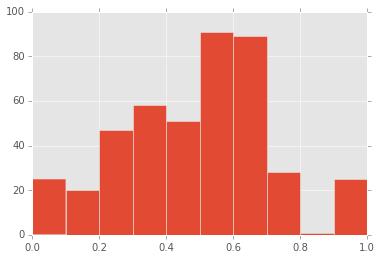

In [288]:
df_previous_results_p.RepublicanRatio.hist()

In [291]:
df_full_independent = df_independent_variables.merge(df_previous_results_p, left_on=["State", "District"], right_on=["state", "clean_district"])

In [ ]:
# model 1: who gives a lot? 
# model 2: who receives a lot?